In [42]:
#Test our best mamba model and transformer solver on 10k test set
import torch
from model import seq2seq_generate_tour,MambaFull, compute_tour_length,generate_data
from benchmarks.transformer_model import TSP_net
from tqdm import tqdm
#from benchmarks.benchmark_solvers import greedy_tsp

coord_dim = 2
city_count = 100
test_size=10000
device = 'cuda'


class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self


checkpoints = [torch.load('mamba/checkpoints/big/BIG_city50_2.pt'),
               torch.load('mamba/checkpoints/big/BIG_city100_2.pt')]

transformer_checkpoints = [torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl'),
                           torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-09-47-n100-gpu0,1.pkl')]




for i, (checkpoint_m, checkpoint_t) in enumerate(zip(checkpoints, transformer_checkpoints)):
    if i==0:
        continue
    args = checkpoint_m['args']
    model = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls,args.B, args.reverse,args.reverse_start,args.mamba2,args.last_layer).to(device)
    model.load_state_dict(checkpoint_m['model_baseline_state_dict'])
    model.eval()

    transformer_model = TSP_net(2, 128, 512, 6, 2, 8, 1000, True).to(device)
    transformer_model.eval()

    if i==0:
        print('CITY 50')
        transformer_model.load_state_dict(checkpoint_t['model_baseline'])
    else:
        print('CITY 100')
        checkpoint_t['model_baseline'] = {k.replace('module.', ''): v for k, v in checkpoint_t['model_baseline'].items()}
        transformer_model.load_state_dict(checkpoint_t['model_baseline'])
    
    #inputs = generate_data(device, 10, city_count, coord_dim=2 , start = 2)
    inputs = torch.load('mamba/evals/figs/inputs50.pt')

    Loss_mamba = []
    Loss_transformer = []
    with torch.no_grad():
        for j in tqdm(range(1000)):
            tours ,_ = seq2seq_generate_tour(device,model,inputs,deterministic=True,lastlayer=args.last_layer,sum_logactions=False)
            Loss_mamba.append(compute_tour_length(inputs,tours))
            # Shuffle the first dimension (dim1) of the input tensor
            num_cities = inputs.size(1) - 1
            random_permutation = torch.randperm(num_cities)
            perm = torch.cat([random_permutation, torch.tensor([inputs.size(1) - 1])])
            

            tours, _ = transformer_model(inputs[:,:-1,:],True)
            Loss_transformer.append(compute_tour_length(inputs,tours))

            inputs = inputs[:, perm, :]

Loss_mamba = torch.stack(Loss_mamba)
Loss_transformer = torch.stack(Loss_transformer)
print(torch.mean(Loss_mamba,0))
print(torch.mean(Loss_transformer,0))
print(torch.std(Loss_mamba,0))
print(torch.std(Loss_transformer,0))
print(Loss_mamba.shape)

CITY 100


100%|██████████| 1000/1000 [07:10<00:00,  2.33it/s]

tensor([6.4756, 5.5959, 6.2055, 6.2646, 5.5201, 6.2706, 6.3227, 6.2196, 6.1859,
        6.4968], device='cuda:0')
tensor([5.9221, 5.4532, 5.9646, 5.8664, 5.4686, 5.9336, 6.2582, 5.8278, 6.0487,
        6.0111], device='cuda:0')
tensor([0.1142, 0.0286, 0.0325, 0.0529, 0.0854, 0.0691, 0.0215, 0.0081, 0.0198,
        0.0441], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
torch.Size([1000, 10])


In [43]:
torch.set_printoptions(precision=20)
print(torch.mean(Loss_mamba,0))
print(torch.mean(Loss_transformer,0))
print(torch.std(Loss_mamba,0))
print(torch.std(Loss_transformer,0))
print(Loss_mamba.shape)

tensor([6.47559642791748046875, 5.59590721130371093750, 6.20545721054077148438,
        6.26464796066284179688, 5.52008247375488281250, 6.27057695388793945312,
        6.32265806198120117188, 6.21956634521484375000, 6.18585681915283203125,
        6.49676704406738281250], device='cuda:0')
tensor([5.92210006713867187500, 5.45322704315185546875, 5.96462249755859375000,
        5.86640691757202148438, 5.46858215332031250000, 5.93361759185791015625,
        6.25822877883911132812, 5.82779026031494140625, 6.04868888854980468750,
        6.01108932495117187500], device='cuda:0')
tensor([0.11419592797756195068, 0.02863270789384841919, 0.03252968937158584595,
        0.05293843522667884827, 0.08541065454483032227, 0.06905212998390197754,
        0.02151884511113166809, 0.00811160914599895477, 0.01984050497412681580,
        0.04406124353408813477], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
torch.Size([1000, 10])


50


100%|██████████| 50/50 [00:00<00:00, 57.71it/s]


torch.Size([10])
Problem Name: e40778878f394891ace3979cd38c87dc
Problem Type: TSP
Number of Nodes: 50
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Setting kick type to close
Starting Cycle: 1295
   0 Steps   Best: 1111   0.00 seconds
   5 Steps   Best: 1109   0.00 seconds
  25 Total Steps.
Best cycle length: 1109
Lin-Kernighan Running Time: 0.00
LK Initial Run: 1109.0
LK Run 0: 1109.0
LK Run from best tour: 1109.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 1109 (from tour)
Fractional Matching: 1106.0
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.00 (seconds)
Setting upperbound to the initial bound: 1109.00
Loading lp...done in 0.00 seconds
LP has:  50 rows  56 columns  112 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 1106.000000
Setting tolerances: next cuts 0.0300 next round 0.00

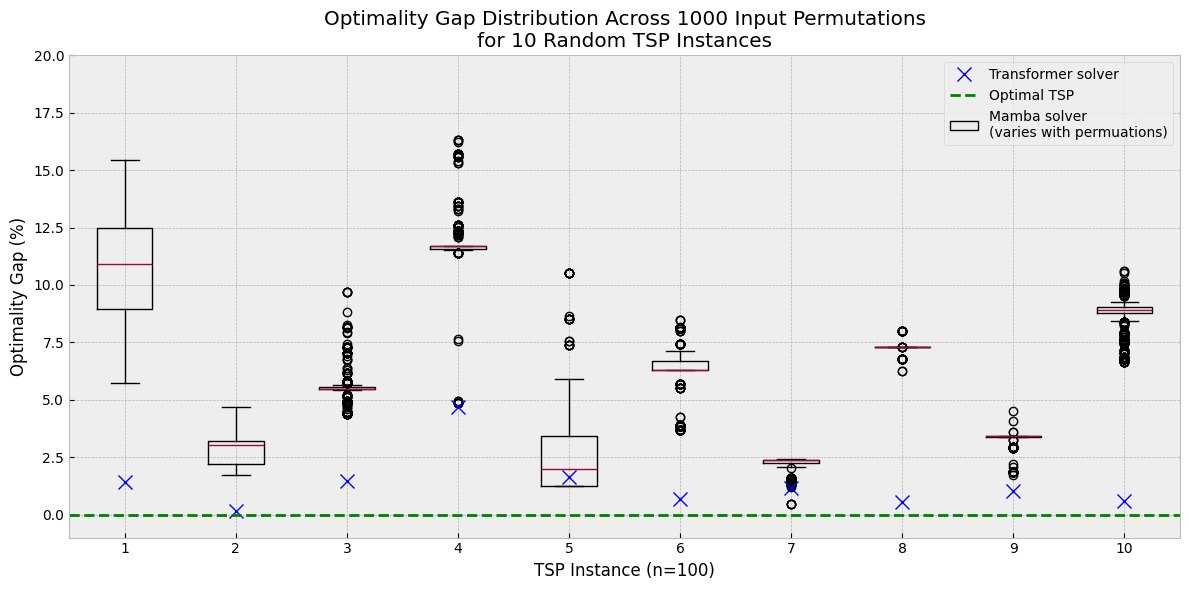

In [48]:
import torch
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
from benchmarks.benchmark_solvers import greedy_tsp
import pandas as pd
from benchmarks.pyconcorde.concorde.tsp import TSPSolver
from model import compute_tour_length
torch.set_printoptions(precision=4)
plt.style.use('bmh')
device = 'cuda'

def create_concorde_tour(test_data):
    x_coord_i = test_data.cpu().numpy()
    graph = pd.DataFrame({'lat': x_coord_i[:,0], 'lon': x_coord_i[:,1]})
    solver = TSPSolver.from_data(graph.lat, graph.lon, norm="GEO")
    solution = solver.solve()
    return torch.tensor(solution.tour)

# Assuming Loss_mamba is a 2D tensor on the GPU
Loss_mamba_greedy = torch.zeros(10, device=device)
Loss_mamba_greedy = greedy_tsp(inputs, return_mean=False)[0]
print(Loss_mamba_greedy.shape)

Optimal_tour = torch.stack([create_concorde_tour(inputs[i, :-1, :]) for i in range(10)]).to(device)
Optimal = compute_tour_length(inputs, Optimal_tour, remove_start_token=False)

# Calculate optimality gap
Optimality_gap_mamba = (Loss_mamba.cuda() / Optimal.cuda() - 1) * 100
Optimality_gap_transformer = (torch.mean(Loss_transformer,0).cuda() / Optimal.cuda() - 1) * 100
Optimality_gap_greedy = (Loss_mamba_greedy.cuda() / Optimal.cuda() - 1) * 100

# Transfer the tensors to the CPU
Optimality_gap_mamba_cpu = Optimality_gap_mamba.cpu()
Optimality_gap_greedy_cpu = Optimality_gap_greedy.cpu()
Optimality_gap_transformer = Optimality_gap_transformer.cpu()

fig, ax = plt.subplots(figsize=(12, 6))

# Create the box plot
bp = ax.boxplot(Optimality_gap_mamba_cpu.permute(1, 0), vert=True)

# Add greedy results as red crosses
x = range(1, 11)  # x-coordinates for the 10 instances
#greedy_plot, = ax.plot(x, Optimality_gap_greedy_cpu, 'rx', markersize=10, label='Greedy solver')
transformer_plot, = ax.plot(x, Optimality_gap_transformer, 'bx', markersize=10, label='Transformer solver')

# Add a horizontal line at y=0 to represent the optimal solution
optimal_line = ax.axhline(y=0, color='g', linestyle='--', linewidth=2)

ax.set_xlabel('TSP Instance (n=100)')
ax.set_ylabel('Optimality Gap (%)')
ax.set_title('Optimality Gap Distribution Across 1000 Input Permutations\nfor 10 Random TSP Instances')
# Create a rectangle patch for Mamba solver
mamba_patch = mpatches.Rectangle((0, 0), 1, 1, fill=False, edgecolor='black', linewidth=1)

# Create a legend with correct colors and markers
legend_elements = [
    transformer_plot,
    optimal_line,
    mamba_patch
]

ax.legend(legend_elements, 
          ['Transformer solver', 'Optimal TSP', 'Mamba solver\n(varies with permuations)'],
          loc='upper right')
plt.ylim(-1,20)

plt.tight_layout()
plt.savefig('mamba/evals/figs/boxplot100.pdf')
plt.show()

In [49]:
torch.save(inputs,'mamba/evals/figs/inputs100.pt')